## Clustering of MODIS Data for Regions 

In [2]:
import numpy as np
import xarray as xr
import rioxarray
import os.path as op
import xrft
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#hycom = xr.open_rasterio('hycom_gs_img.tif')
#modis = xr.open_rasterio('stacked_sst-0000000000-0000000000.tif')
modis_sst = xr.open_rasterio('stacked_sst_171819.tif')
modis_chl = xr.open_rasterio('stacked_chl_171819.tif')

In [282]:
modis_sst

<xarray.DataArray (band: 1050, y: 177, x: 344)>
array([[[      nan,       nan, ...,  6.      ,       nan],
        [      nan,       nan, ...,  6.      ,       nan],
        ...,
        [      nan,       nan, ...,  0.      ,       nan],
        [      nan,       nan, ...,  0.      ,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ..., 22.234999, 22.279999],
        [      nan,       nan, ..., 22.095   , 22.119999]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]]], dtype=float32)
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 ... 1044 1045 1046 1047 1048 1049 1050
  * y        (y) float64 38.53 38.49 38.45 38.42 ... 32.31 32.27 32.24 32.2
  * x        (x) float64 -78.29 -78.26 -78.22 -78.18 ... -66.04 -66.0 -65.97
Attributes:
    transform:      (0.035932610856930364, 0.0, -78.31071636173886, 0.0, -0.0...
    crs:            +init=epsg:4326
    res:            (0.035932610856930364, 0.03593261187263137)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n...
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1...
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
    AREA_OR_POINT:  Area

In [4]:
modis_sst = modis_sst.sel(band=slice(1,1050))
modis_chl = modis_chl.sel(band=slice(1,1050))

modis_sst_subset = modis_sst.sel(x=slice(-75,-66))
modis_chl_subset = modis_chl.sel(x=slice(-75,-66))

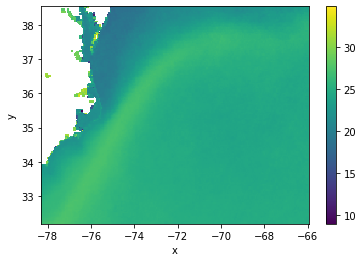

In [5]:
modis_sst.mean(dim='band').plot()

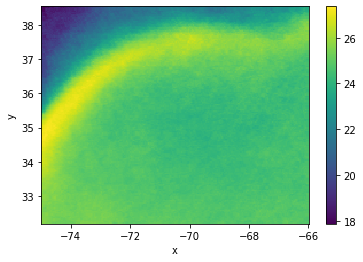

In [6]:
modis_sst_subset = modis_sst.sel(x=slice(-75,-66), band=slice(1,1000))
modis_sst_subset.mean(dim='band').plot()

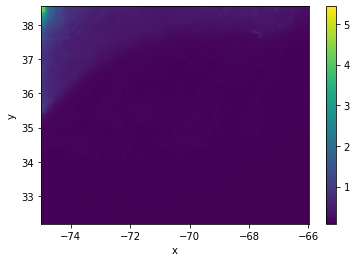

In [7]:
modis_chl_subset = modis_chl.sel(x=slice(-75,-66), band=slice(1,1000))
modis_chl_subset.mean(dim='band').plot()

In [586]:
modis_sst_subset = modis_sst.sel(band=slice(1,1020))
modis_chl_subset = modis_chl.sel(band=slice(1,1020))

In [587]:
modis_sst_subset.shape

(1020, 177, 344)

In [588]:
1020 / 30

34.0

In [590]:
#reshape to flatten it
X = np.array(modis_sst_subset).reshape(1020,177*344)
# split it into a couple subsets along time time dimension and then take the average of each subset
X = np.nanmean(X.reshape(-1, 30, 177*344), axis=1)
np.count_nonzero(np.isnan(X))

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


276324

In [591]:
Xc = np.array(modis_chl_subset).reshape(1020,177*344)
Xc = np.nanmean(Xc.reshape(-1, 30, 177*344), axis=1)
np.count_nonzero(np.isnan(Xc))

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


350438

In [592]:
Xsc = np.concatenate((Xc, X), axis=0)

In [606]:
# make a mask to ignore all the nan pixels
mask = np.isnan(Xc).any(axis=0)
mask.shape, Xc.shape

((60888,), (34, 60888))

In [607]:
mask

array([ True,  True,  True, ..., False, False, False])

In [608]:
#need to do https://stackoverflow.com/questions/15956309/averaging-over-every-n-elements-of-a-numpy-array
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(Xc[:,~mask].T)
kmeans.labels_

array([8, 8, 8, ..., 2, 2, 2], dtype=int32)

In [609]:
cluster_arr = np.zeros(177*344)
cluster_arr.shape

(60888,)

In [610]:
cluster_arr[~mask] = kmeans.labels_ +1

In [611]:
np.unique(kmeans.labels_+1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


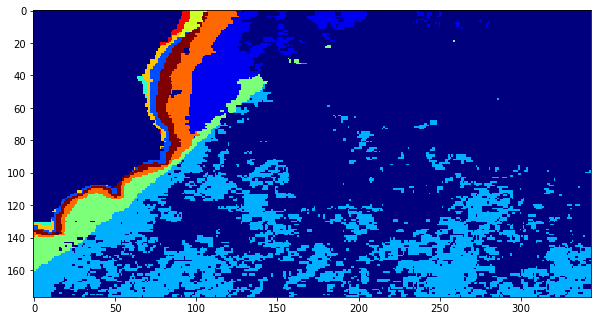

In [612]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(cluster_arr.reshape(177,344), interpolation='nearest', cmap='jet')
fig.show()

In [613]:
len(np.unique(cluster_arr)), len(clust_colors)

(11, 11)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


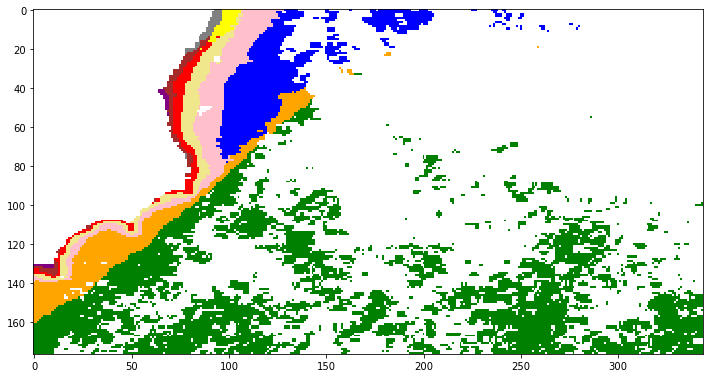

In [614]:
from matplotlib import colors
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,14))
clust_colors= ['white','blue','red','green','purple','orange','yellow','brown','pink','grey', 'khaki']#,
              #'palegreen', 'coral', 'saddlebrown', 'skyblue', 'orchid']

c_map = colors.ListedColormap(clust_colors)
ax.imshow(cluster_arr.reshape(177,344), interpolation='nearest', cmap=c_map)
#plt.savefig('gulfstream_clusters.png', dpi=300)
fig.show()

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


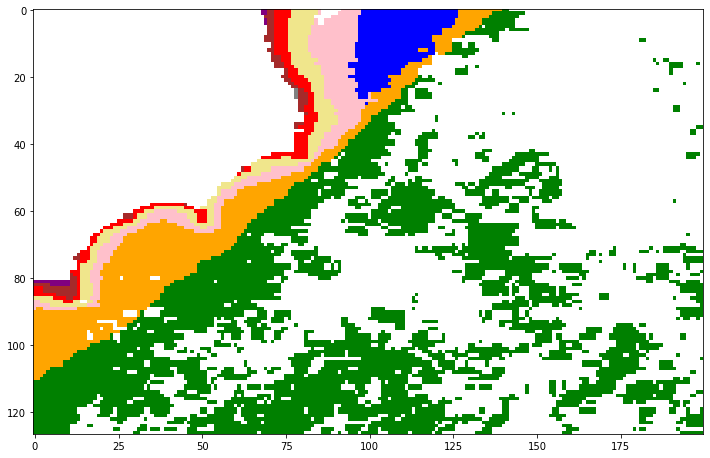

In [615]:
from matplotlib import colors
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(12,14))
clust_colors= ['white','blue','red','green','purple','orange','yellow','brown','pink','grey', 'khaki']#,
              #'palegreen', 'coral', 'saddlebrown', 'skyblue', 'orchid']

c_map = colors.ListedColormap(clust_colors)
ax.imshow(cluster_arr.reshape(177,344)[50:,:200], interpolation='nearest', cmap=c_map)
#plt.savefig('gulfstream_clusters.png', dpi=300)
fig.show()

red,khaku,pink,orange,green,
2,10,8,5,3

In [602]:
np.unique(cluster_arr, return_counts=True)


(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 array([42432, 11230,    74,   126,   544,    24,   216,  1512,  4619,
           41,    70]))

In [604]:
labs_r = np.repeat(cluster_arr[np.newaxis,:], Xc.shape[0], axis=0)
labs_r.shape

(34, 60888)

In [605]:
for i in [2,3,5,6,9,10]:
    Xc[labs_r == i] = np.nan

Look into the average of each cluster and display it in a dendrogram to see how similar some are or maybe just look up how to do that in kmeans

In [342]:
kmeans.cluster_centers_.shape

(7, 40)

In [616]:
from sklearn.decomposition import PCA
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = kmeans.cluster_centers_.T
pca = PCA(n_components=3)
pca.fit(X)
pca.components_.shape

(3, 10)

In [617]:
pca.components_.T[:,1]

array([ 0.0034734 , -0.1474451 , -0.00608099, -0.6103846 , -0.03772386,
        0.37951946, -0.16736016,  0.02473595,  0.65394014, -0.06264652],
      dtype=float32)

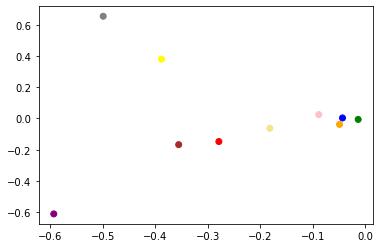

In [618]:
pca.components_.T
plt.scatter(pca.components_.T[:,0], pca.components_.T[:,1], color=clust_colors[1:])

Take the clusters and for each one visualize their average 3 year history in chla, sst, cloudiness, variability (STD) in a series of plots

In [541]:
import matplotlib.dates as mdates
import datetime as dt

N = 1050
now = dt.datetime.strptime('Jan 1 2017', '%b %d %Y')
then = now + dt.timedelta(days=N)
days = mdates.drange(now,then,dt.timedelta(days=1))

N = 1030
now = dt.datetime.strptime('Jan 1 2017', '%b %d %Y')
then = now + dt.timedelta(days=N)
days_avg = mdates.drange(now,then,dt.timedelta(days=1))

In [619]:
labs = cluster_arr.reshape(177,344)
labs_repeat = np.repeat(labs[np.newaxis,:, :], modis_sst.shape[0], axis=0)
labs_repeat.shape

(1050, 177, 344)

In [620]:
np.unique(cluster_arr)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaco

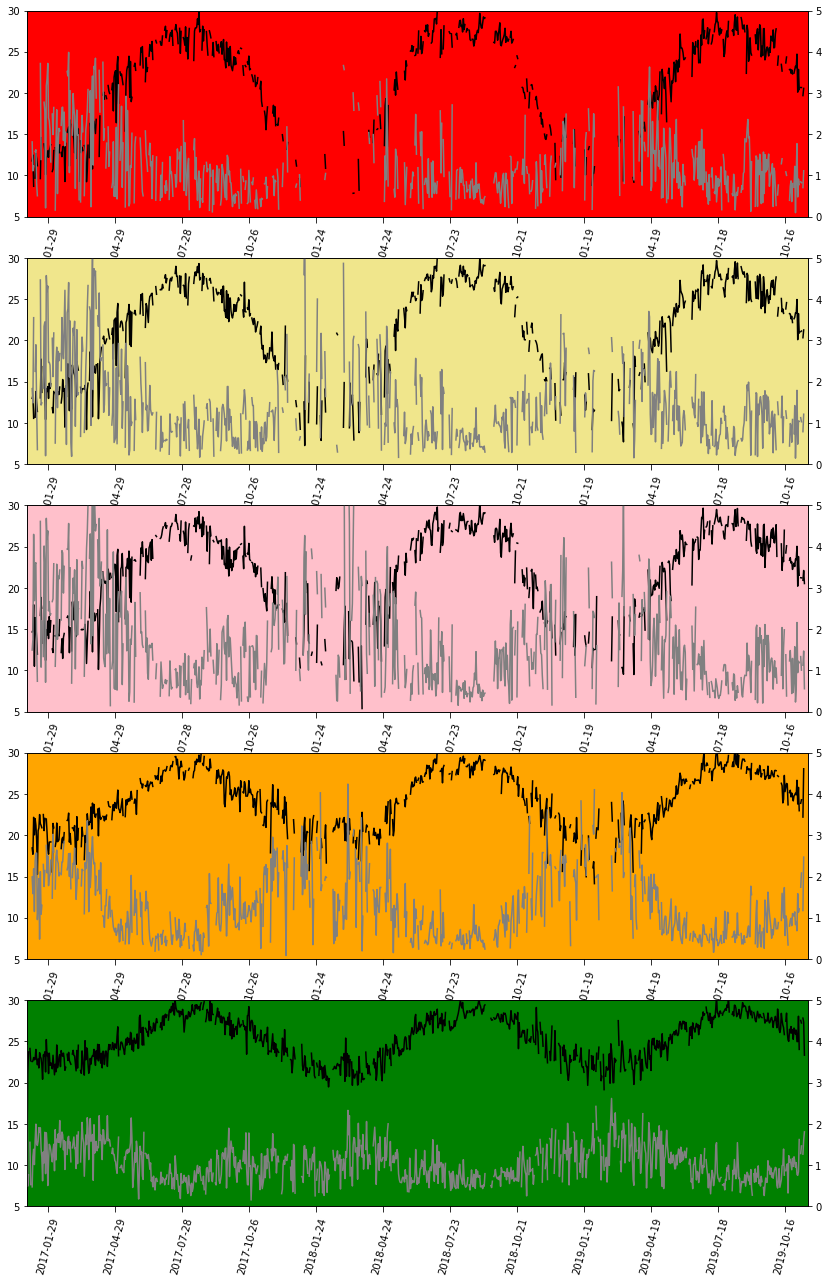

In [621]:
to_iter = [2,10,8,5,3]
fig, ax = plt.subplots(len(to_iter), 1, figsize=(14,22))
for i, lab in enumerate(to_iter):
    ax[i].set_facecolor(clust_colors[lab])
    ax2 = ax[i].twinx()
    modis_sst_cp = modis_sst.copy(deep=True)
    modis_sst_cp.values[labs_repeat != lab] = np.nan
    modis_sst_cp = modis_sst_cp[:,60:,:200]
    sst_avg = np.nanmedian(modis_sst_cp, axis=(1,2))
    sst_avg[np.count_nonzero(~np.isnan(modis_sst_cp),axis=(1,2)) < 15] = np.nan
    
    sst_std = np.nanstd(modis_sst_cp, axis=(1,2))
    sst_std[np.count_nonzero(~np.isnan(modis_sst_cp),axis=(1,2)) < 15] = np.nan
    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=90))
    ax[i].tick_params('x', labelrotation=75, length=6)
    ax[i].set_xlim(days[0], days[-1])
    ax[i].set_ylim(5, 30)
    ax2.set_ylim(0, 5)
    
    ax[i].plot(days, sst_avg, color='black')
    ax2.plot(days, sst_std, color='grey')
#plt.savefig('gulfstream_clusters_sst.png', dpi=300)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = 

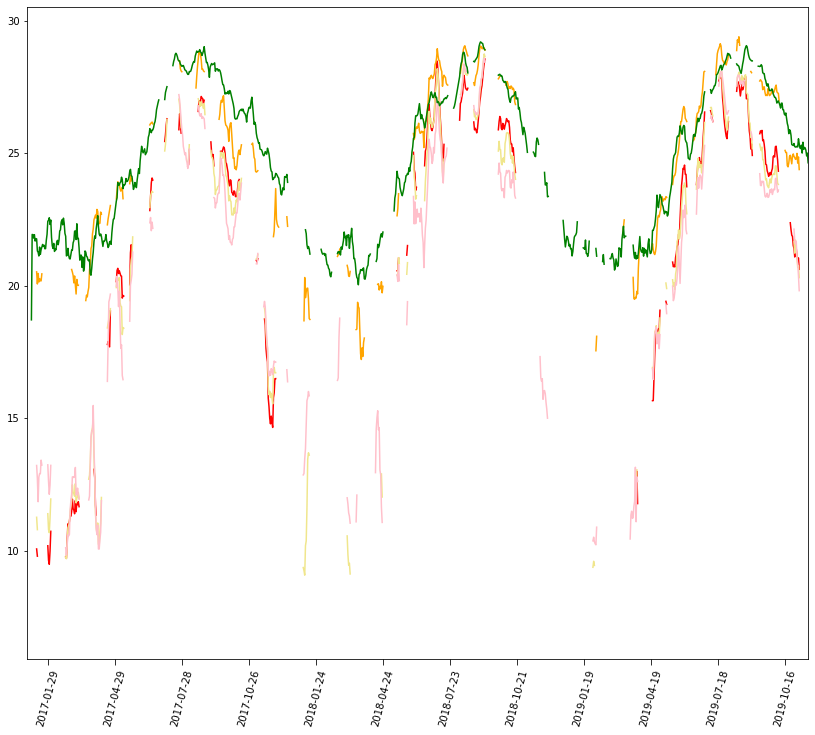

In [622]:

fig, ax = plt.subplots(figsize=(14,12))
for i, lab in enumerate(to_iter):
    #ax[i].set_facecolor(clust_colors[i])
    #ax2 = ax[i].twinx()
    modis_sst_cp = modis_sst.copy(deep=True)
    modis_sst_cp.values[labs_repeat != lab] = np.nan
    sst_avg = np.nanmedian(modis_sst_cp, axis=(1,2))
    sst_avg[np.count_nonzero(~np.isnan(modis_sst_cp),axis=(1,2)) < 0] = np.nan
    
    #sst_std = np.nanstd(modis_sst_cp, axis=(1,2))
    #sst_std[np.count_nonzero(~np.isnan(modis_sst_cp),axis=(1,2)) < 15] = np.nan
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=90))
    ax.tick_params('x', labelrotation=75, length=6)
    ax.set_xlim(days[0], days[-1])
    
    
    N=7
    running_avg_sst = np.convolve(sst_avg, np.ones((N,))/N, mode='valid')
    ax.plot(days[6:], running_avg_sst, color=clust_colors[lab])
    #ax2.plot(days, sst_std, color='grey')
#plt.savefig('gulfstream_clusters_sst.png', dpi=300)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


2.0927396


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


1.3556846


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


0.8392177


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


0.42933068


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


0.12955762


/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


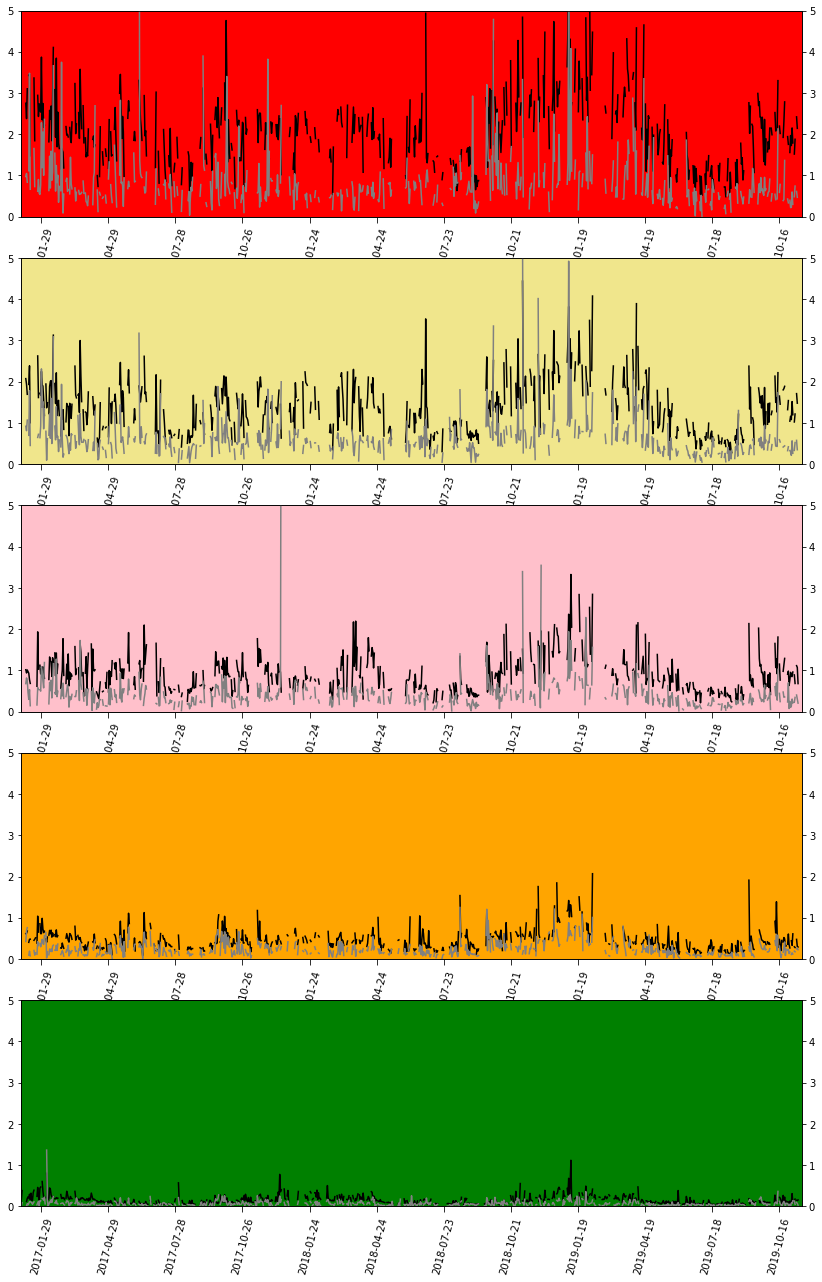

In [624]:
fig, ax = plt.subplots(len(to_iter), 1, figsize=(14,22))
for i, lab in enumerate(to_iter):
    ax[i].set_facecolor(clust_colors[lab])
    ax2 = ax[i].twinx()
    
    modis_chl_cp = modis_chl.copy(deep=True)
    modis_chl_cp.values[labs_repeat != lab] = np.nan
    modis_chl_cp = modis_chl_cp[:,60:,:200]
    chl_avg = np.nanmedian(modis_chl_cp, axis=(1,2))
    chl_avg[np.count_nonzero(~np.isnan(modis_chl_cp),axis=(1,2)) < 15] = np.nan
    print(np.nanmedian(modis_chl_cp))
    
    chl_std = np.nanstd(modis_chl_cp, axis=(1,2))
    chl_std[np.count_nonzero(~np.isnan(modis_chl_cp),axis=(1,2)) < 15] = np.nan
    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=90))
    ax[i].tick_params('x', labelrotation=75, length=6)
    ax[i].set_xlim(days[0], days[-1])
    ax[i].set_ylim(0,5)
    ax2.set_ylim(0,5)
    
    ax[i].plot(days, chl_avg, color='black')
    ax2.plot(days, chl_std, color='grey')
#plt.savefig('gulfstream_clusters_chl.png', dpi=300)

In [169]:
np.count_nonzero(~np.isnan(modis_sst.values[:,cluster_arr.reshape(177,344) == 1]))

78051

1050